"""
# 🌟 BAKERY-Spectra-Classification Project
## Data Visualization and Processing

This notebook contains three main components:
1. 📊 Storage Conditions Visualization
2. 📈 Data Processing and Feature Extraction
3. 🔄 Data Augmentation

### Dataset Information
- **Products**: Bread (A) and Cookies (B)
- **Storage Conditions**: Open (1), Wrapped (2), Humid (3)
- **Measurements**: Frequency (300-900 MHz), Gain, Phase
"""

"""
## 📊 Part 1: Storage Conditions Visualization
Visualize frequency vs. gain for different storage conditions and product types
"""

In [43]:
# Storage Conditions Visualization
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

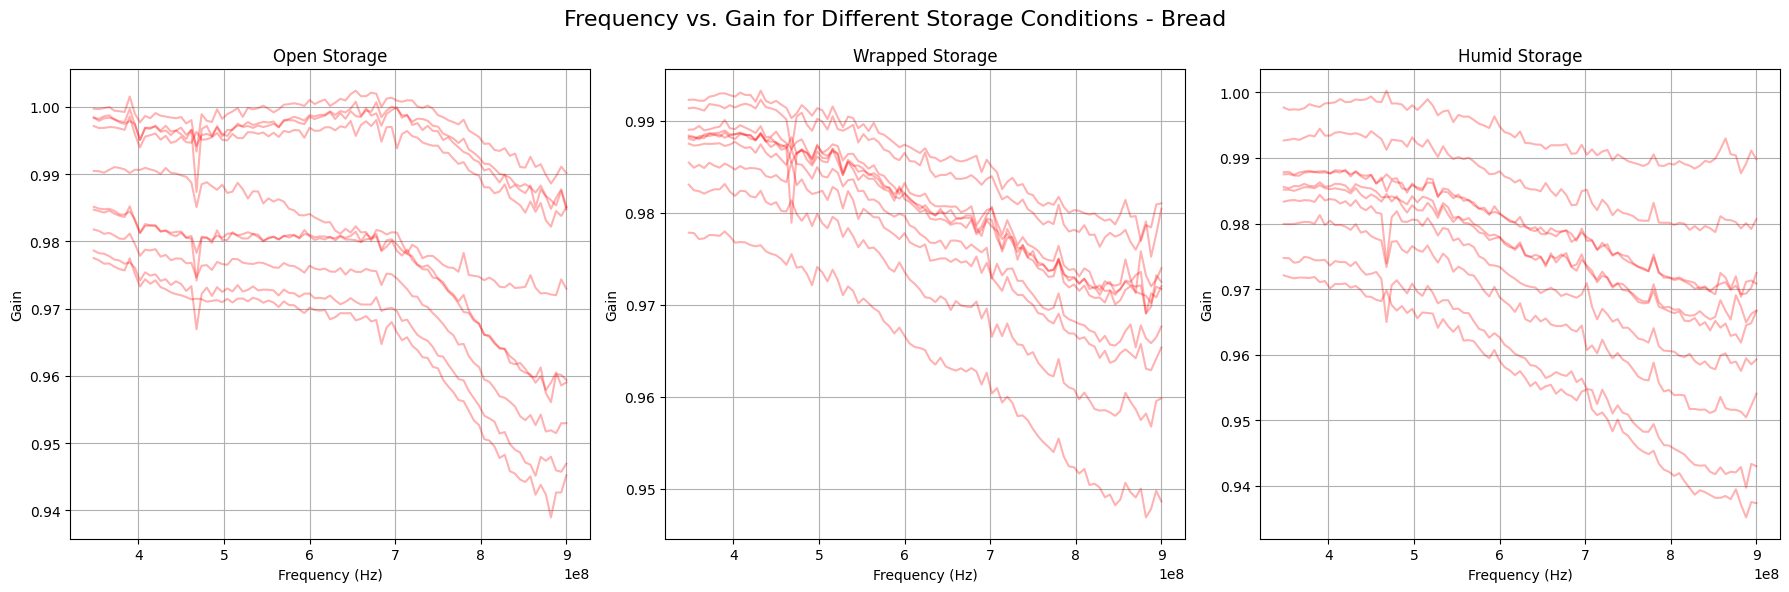

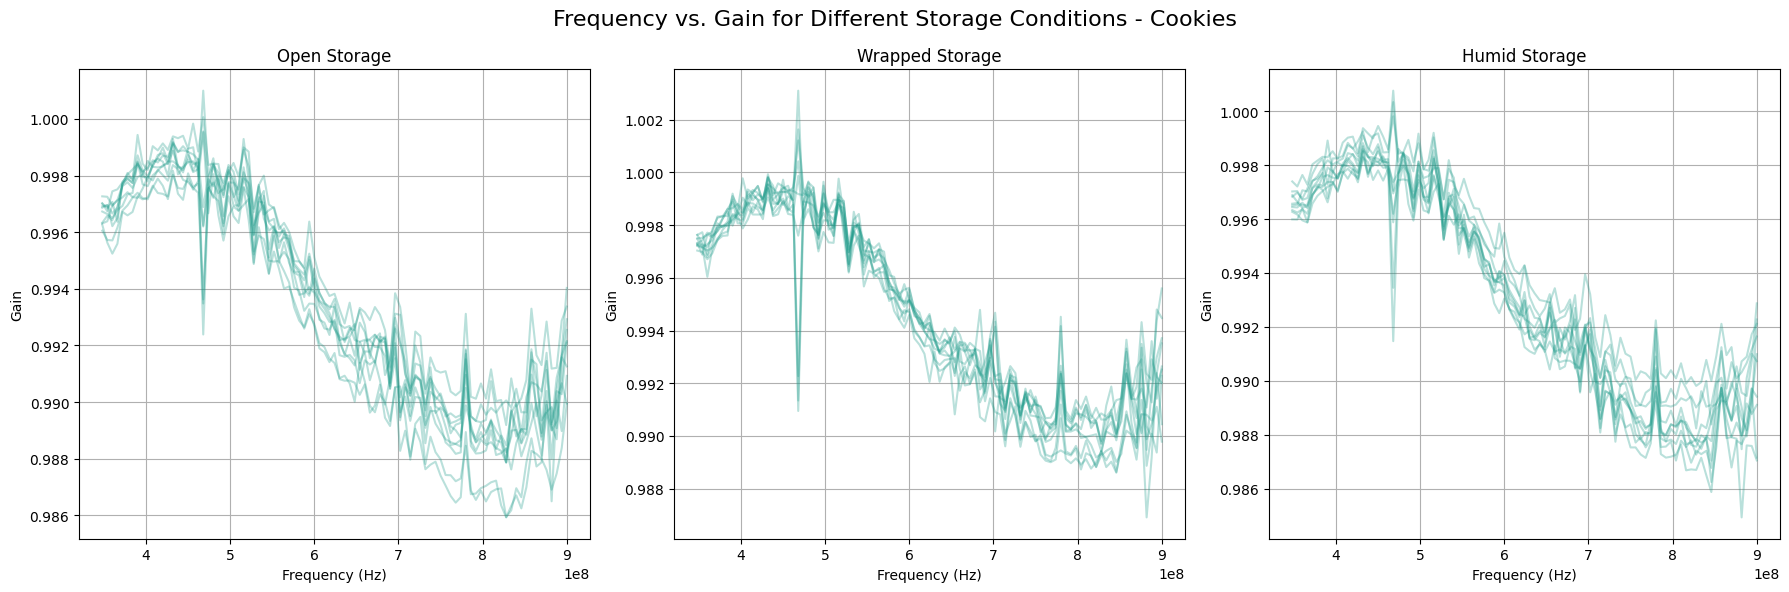

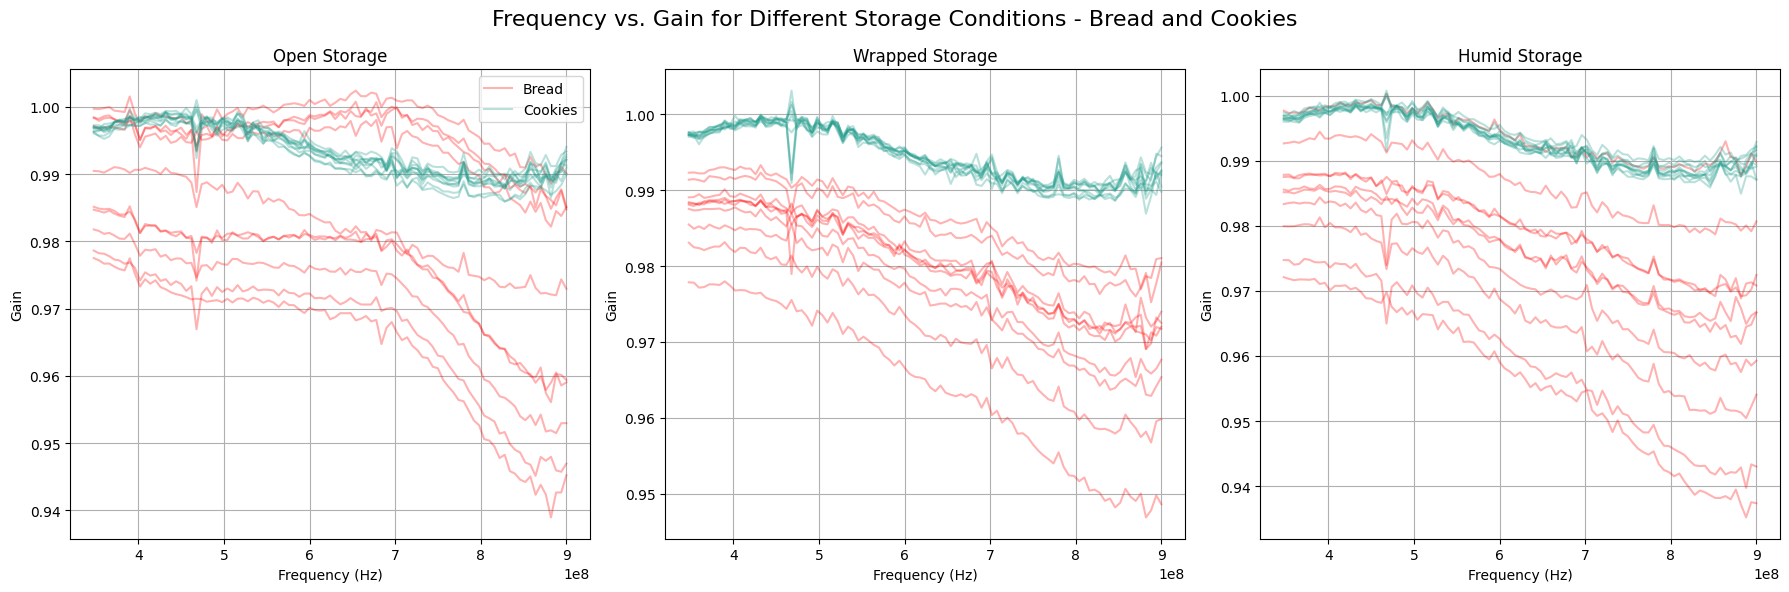

In [44]:

def load_s1p_data(file_path):
    """Load data from s1p file"""
    data = np.loadtxt(file_path, skiprows=9)  # Skip header rows  
    freq = data[:, 0]
    gain = data[:, 1]
    return freq, gain

def extract_metadata(filename):
    """Extract product type (bread/cookies) and storage condition from filename"""
    # Format: A/B_1/2/3_1.s1p where:
    # A = bread, B = cookies
    # 1/2/3 = storage (1:Open, 2:Wrapped, 3:Humid)
    # Last number = sample number
    base = os.path.basename(filename)
    product_code = base[0]  # A or B
    product_type = 'Bread' if product_code == 'A' else 'Cookies'
    storage_num = int(base.split('_')[1])
    
    storage_map = {1: 'Open', 2: 'Wrapped', 3: 'Humid'}
    storage = storage_map[storage_num]
    
    return product_code, product_type, storage

def plot_storage_conditions(product_code=None):
    """Create separate plots for each storage condition for specified product type"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    title_suffix = {
        'A': 'Bread',
        'B': 'Cookies',
        None: 'Bread and Cookies'
    }[product_code]
    
    fig.suptitle(f'Frequency vs. Gain for Different Storage Conditions - {title_suffix}', 
                fontsize=16)
    
    pattern = (f'./RawData/Bakery/{product_code}_*_*.s1p' if product_code 
              else './RawData/Bakery/[A-B]_*_*.s1p')
    files = glob.glob(pattern)
    
    storage_data = {'Open': [], 'Wrapped': [], 'Humid': []}
    
    for file_path in files:
        freq, gain = load_s1p_data(file_path)
        prod_code, prod_type, storage = extract_metadata(file_path)
        storage_data[storage].append((freq, gain, prod_type))
    
    color_map = {'Bread': 'red', 'Cookies': '#1a9988'}
    
    for ax, (title, data) in zip([ax1, ax2, ax3], 
                               [('Open Storage', storage_data['Open']),
                                ('Wrapped Storage', storage_data['Wrapped']),
                                ('Humid Storage', storage_data['Humid'])]):
        ax.set_title(title)
        for freq, gain, prod_type in data:
            ax.plot(freq, gain, alpha=0.3, color=color_map[prod_type], 
                   label=prod_type)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Gain')
        ax.grid(True)
    
    if not product_code:
        handles, labels = ax1.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax1.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    plt.tight_layout()
    
    product_name = {
        'A': 'bread',
        'B': 'cookies',
        None: 'bread_and_cookies'
    }[product_code]
    filename = f'storage_conditions_comparison_{product_name}.png'
    plt.savefig(filename)
    plt.show()

# Example usage:
plot_storage_conditions('A')  # For Bread samples
plot_storage_conditions('B')  # For Cookie samples
plot_storage_conditions()     # For both Bread and Cookies


"""
## 📈 Part 2: Data Processing and Feature Extraction
Process raw data files and create structured dataset with features
"""

In [45]:
# Imports and Utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob as glob_pattern  # Rename glob to avoid conflict

def load_s1p_file(file_path):
    """
    Load an s1p file and return frequency, gain, and phase data
    Skip the metadata row (first row)
    """
    try:
        # Skip the first row (metadata) and load the data
        data = pd.read_csv(file_path, delimiter=r'\s+', header=None, skiprows=1)
        
        # Verify we have 101 rows of data
        if len(data) != 101:
            print(f"Warning: {file_path} has {len(data)} rows instead of 101")
            
        frequency = data.iloc[:, 0]
        gain = data.iloc[:, 1]
        phase = data.iloc[:, 2]
        
        return frequency, gain, phase
    except Exception as e:
        print(f"Error loading file {file_path}: {str(e)}")
        return None, None, None

def extract_metadata(filename):
    """
    Extract product type and storage condition from filename
    Example: A_1_1.s1p -> Product Type: A (bread), Storage: 1 (open)
    """
    parts = os.path.basename(filename).split('_')
    product_type = 'Bread' if parts[0] == 'A' else 'Cookies'
    storage_condition = {
        '1': 'Open',
        '2': 'Wrapped',
        '3': 'Humid'
    }.get(parts[1], 'Unknown')
    
    return product_type, storage_condition

def create_dataset(data_folder):
    """
    Create a dataset from all s1p files in the folder
    """
    # Get all s1p files
    s1p_files = glob_pattern(os.path.join(data_folder, '*.s1p'))
    s1p_files.sort()  # Sort files to ensure consistent ordering
    
    if not s1p_files:
        raise ValueError(f"No .s1p files found in {data_folder}")

    # Lists to store data
    all_features = []
    metadata = []

    # Process each file
    for file_path in s1p_files:
        # Load data
        frequency, gain, phase = load_s1p_file(file_path)
        
        if gain is None or phase is None:
            continue
            
        # Verify we have 101 values for both gain and phase
        if len(gain) != 101 or len(phase) != 101:
            print(f"Skipping {file_path}: Invalid data length")
            continue
            
        # Concatenate gain and phase as features
        features = np.concatenate([gain, phase])
        
        # Extract metadata
        product_type, storage = extract_metadata(file_path)
        
        # Append to lists
        all_features.append(features)
        metadata.append({
            'Filename': os.path.basename(file_path),
            'Product_Type': product_type,
            'Storage_Condition': storage
        })

    # Convert features to numpy array
    X = np.array(all_features)
    
    # Create feature names
    feature_names = ([f'gain_{i}' for i in range(101)] + 
                    [f'phase_{i}' for i in range(101)])
    
    # Create feature dictionary
    feature_dict = {name: X[:, i] for i, name in enumerate(feature_names)}
    
    # Create metadata DataFrame
    metadata_df = pd.DataFrame(metadata)
    
    # Create features DataFrame
    features_df = pd.DataFrame(feature_dict)
    
    # Combine metadata and features
    df = pd.concat([metadata_df, features_df], axis=1)
    
    return df

# Cell 3: [Code] - Main Execution
def main():
    # Set the path to your data folder
    data_folder = './RawData/Bakery'  # Adjust this path as needed
    
    try:
        # Create the dataset
        print("Processing files...")
        df = create_dataset(data_folder)
        
        # Save the processed dataset
        output_file = 'processed_bakery_data.csv'
        df.to_csv(output_file, index=False)
        
        print(f"\nDataset created successfully!")
        print(f"Shape: {df.shape}")
        print(f"\nNumber of samples processed: {len(df)}")
        print(f"Number of features: {len(df.columns) - 3}")  # Subtract 3 for metadata columns
        
        # Print some basic information
        print("\nProduct Type distribution:")
        print(df['Product_Type'].value_counts())
        print("\nStorage Condition distribution:")
        print(df['Storage_Condition'].value_counts())
        
        # Verify feature dimensions
        print("\nFeature verification:")
        print(f"Number of gain features: {len([col for col in df.columns if col.startswith('gain')])}")
        print(f"Number of phase features: {len([col for col in df.columns if col.startswith('phase')])}")
        
        # Display first few columns to verify order
        print("\nFirst few columns:")
        print(df.columns[:10].tolist())
        
        # Save a sample of the data (first 5 rows) to a separate file for verification
        df.head().to_csv('sample_processed_data.csv', index=False)
        print("\nSample data saved to 'sample_processed_data.csv' for verification")
        
    except Exception as e:
        print(f"Error creating dataset: {str(e)}")

if __name__ == "__main__":
    main()

Processing files...

Dataset created successfully!
Shape: (60, 205)

Number of samples processed: 60
Number of features: 202

Product Type distribution:
Product_Type
Bread      30
Cookies    30
Name: count, dtype: int64

Storage Condition distribution:
Storage_Condition
Open       20
Wrapped    20
Humid      20
Name: count, dtype: int64

Feature verification:
Number of gain features: 101
Number of phase features: 101

First few columns:
['Filename', 'Product_Type', 'Storage_Condition', 'gain_0', 'gain_1', 'gain_2', 'gain_3', 'gain_4', 'gain_5', 'gain_6']

Sample data saved to 'sample_processed_data.csv' for verification


In [46]:
# Load the processed data
data = pd.read_csv('processed_bakery_data.csv')

# First few columns should be metadata
print("First columns:", data.columns[:5])

# Verify the order
assert data.columns[0] == 'Filename'
assert data.columns[1] == 'Product_Type'
assert data.columns[2] == 'Storage_Condition'

First columns: Index(['Filename', 'Product_Type', 'Storage_Condition', 'gain_0', 'gain_1'], dtype='object')


"""
## 🔄 Part 3: Data Augmentation
Augment the dataset by adding noise variations
"""

In [47]:
import pandas as pd
import numpy as np

def add_gaussian_noise(data, noise_level):
    """
    Add Gaussian noise to gain values while preserving phases
    
    Parameters:
    data: DataFrame containing the original data
    noise_level: Standard deviation of the Gaussian noise
    """
    # Create a copy of the original data
    noisy_data = data.copy()
    
    # Get gain column names
    gain_columns = [col for col in data.columns if col.startswith('gain')]
    
    # Add noise only to gain values
    for col in gain_columns:
        original_values = noisy_data[col].values
        noise = np.random.normal(0, noise_level, size=len(original_values))
        noisy_data[col] = original_values + noise
        
        # Ensure gains stay in reasonable range (0 to 1)
        noisy_data[col] = np.clip(noisy_data[col], 0, 1)
    
    return noisy_data

def augment_dataset(input_file, output_file):
    """
    Augment the dataset by adding noise-based samples
    """
    # Load the original data
    print("Loading original data...")
    original_data = pd.read_csv(input_file)
    
    # Define noise levels
    low_noise_level = 0.001   # Low noise (0.1% of signal)
    high_noise_level = 0.005  # Higher noise (0.5% of signal)
    
    # Generate noisy versions
    print("Generating low-noise samples...")
    low_noise_data = add_gaussian_noise(original_data, low_noise_level)
    print("Generating high-noise samples...")
    high_noise_data = add_gaussian_noise(original_data, high_noise_level)
    
    # Add noise level indicator to filenames
    low_noise_data['Filename'] = low_noise_data['Filename'].apply(lambda x: f"low_noise_{x}")
    high_noise_data['Filename'] = high_noise_data['Filename'].apply(lambda x: f"high_noise_{x}")
    
    # Concatenate all datasets
    print("Combining datasets...")
    augmented_data = pd.concat([original_data, low_noise_data, high_noise_data], 
                              axis=0, ignore_index=True)
    
    # Save augmented dataset
    print("Saving augmented dataset...")
    augmented_data.to_csv(output_file, index=False)
    
    # Print summary statistics
    print("\nAugmentation Summary:")
    print(f"Original samples: {len(original_data)}")
    print(f"Total augmented samples: {len(augmented_data)}")
    
    print("\nProduct Type distribution:")
    print(augmented_data['Product_Type'].value_counts())
    
    print("\nStorage Condition distribution:")
    print(augmented_data['Storage_Condition'].value_counts())
    
    print("\nGain Values Statistics:")
    gain_columns = [col for col in original_data.columns if col.startswith('gain')]
    print(f"Original data mean: {original_data[gain_columns].mean().mean():.6f}")
    print(f"Low noise data mean: {low_noise_data[gain_columns].mean().mean():.6f}")
    print(f"High noise data mean: {high_noise_data[gain_columns].mean().mean():.6f}")

    return original_data, low_noise_data, high_noise_data, augmented_data

# Define the main function
# Execute augmentation
input_file = 'processed_bakery_data.csv'
output_file = 'augmented_bakery_data.csv'

try:
    original_data, low_noise_data, high_noise_data, augmented_data = augment_dataset(input_file, output_file)
    print(f"\nAugmented dataset saved to {output_file}")
    
except Exception as e:
    print(f"Error during data augmentation: {str(e)}")

Loading original data...
Generating low-noise samples...
Generating high-noise samples...
Combining datasets...
Saving augmented dataset...

Augmentation Summary:
Original samples: 60
Total augmented samples: 180

Product Type distribution:
Product_Type
Bread      90
Cookies    90
Name: count, dtype: int64

Storage Condition distribution:
Storage_Condition
Open       60
Wrapped    60
Humid      60
Name: count, dtype: int64

Gain Values Statistics:
Original data mean: 0.986492
Low noise data mean: 0.986485
High noise data mean: 0.986212

Augmented dataset saved to augmented_bakery_data.csv


In [48]:

# Define the main function
# Execute augmentation
input_file = 'processed_bakery_data.csv'
output_file = 'augmented_bakery_data.csv'

try:
    original_data, low_noise_data, high_noise_data, augmented_data = augment_dataset(input_file, output_file)
    print(f"\nAugmented dataset saved to {output_file}")
    
except Exception as e:
    print(f"Error during data augmentation: {str(e)}")

Loading original data...
Generating low-noise samples...
Generating high-noise samples...
Combining datasets...
Saving augmented dataset...

Augmentation Summary:
Original samples: 60
Total augmented samples: 180

Product Type distribution:
Product_Type
Bread      90
Cookies    90
Name: count, dtype: int64

Storage Condition distribution:
Storage_Condition
Open       60
Wrapped    60
Humid      60
Name: count, dtype: int64

Gain Values Statistics:
Original data mean: 0.986492
Low noise data mean: 0.986470
High noise data mean: 0.986142

Augmented dataset saved to augmented_bakery_data.csv


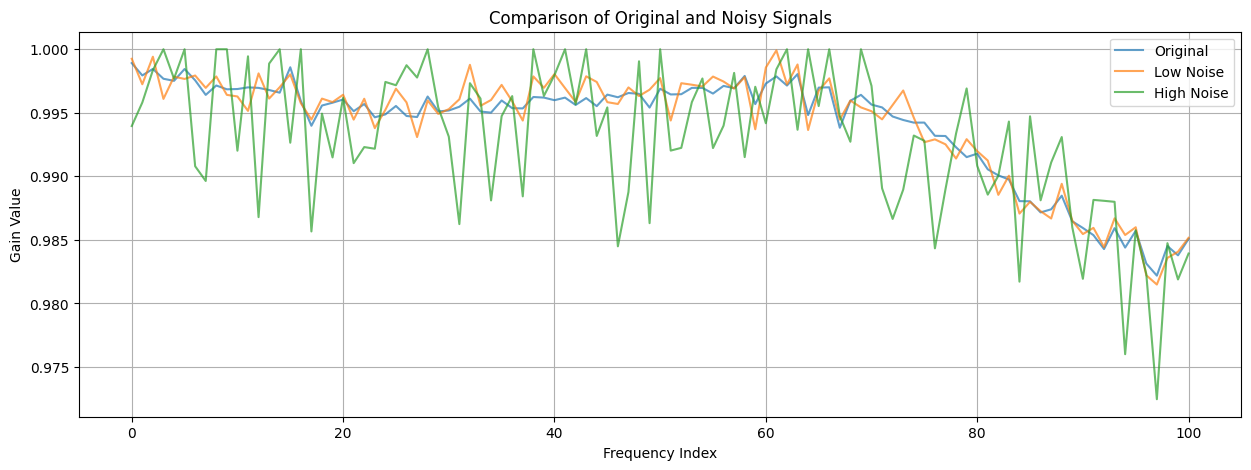

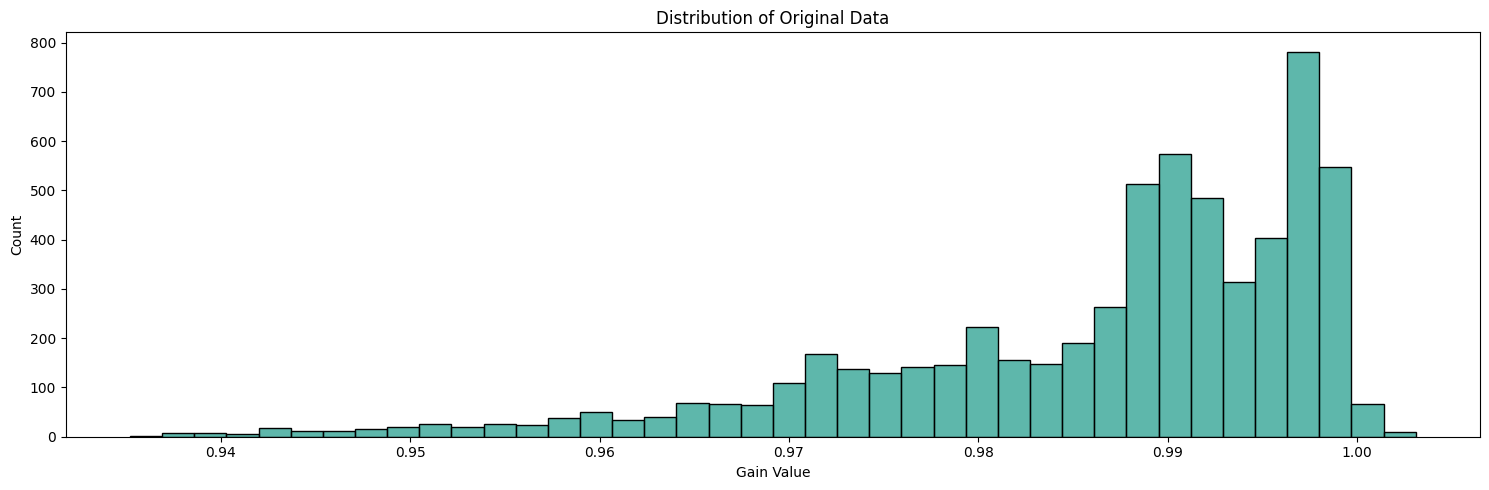

Visualization saved as 'augmentation_analysis.png'


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_augmentation_results(original_data, low_noise_data, high_noise_data):
    """
    Create two plots:
    1. Signal comparison between original and noisy versions
    2. Distribution of original data
    """
    # Get gain columns
    gain_columns = [col for col in original_data.columns if col.startswith('gain')]
    
    # Create figure with two subplots
    plt.figure(figsize=(15, 5))    
    # 1. Signal Comparison Plot
    sample_idx = 0  # First sample
    gain_values = range(101)
    
    plt.plot(gain_values, original_data.iloc[sample_idx][gain_columns], 
             label='Original', alpha=0.7)
    plt.plot(gain_values, low_noise_data.iloc[sample_idx][gain_columns], 
             label='Low Noise', alpha=0.7)
    plt.plot(gain_values, high_noise_data.iloc[sample_idx][gain_columns], 
             label='High Noise', alpha=0.7)
    
    plt.title('Comparison of Original and Noisy Signals')
    plt.xlabel('Frequency Index')
    plt.ylabel('Gain Value')
    plt.legend()
    plt.grid(True)
    plt.savefig('signal_comparison.png')
    plt.show()
    
    plt.figure(figsize=(15, 5))
    # 2. Original Data Distribution
    sns.histplot(data=original_data[gain_columns].values.ravel(), 
                color='#1a9988', alpha=0.7)
    plt.title('Distribution of Original Data')
    plt.xlabel('Gain Value')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.savefig('augmentation_analysis.png')
    plt.show()
    
# Define the main function
def main():
    # Execute visualization
    try:
        visualize_augmentation_results(original_data, low_noise_data, high_noise_data)
        print("Visualization saved as 'augmentation_analysis.png'")
    except Exception as e:
        print(f"Error during visualization: {str(e)}")

if __name__ == "__main__":
    main()

Loading augmented data...

Gain Features Statistics:
         gain_0    gain_1    gain_2    gain_3    gain_4    gain_5    gain_6  \
count  4.000000  4.000000  4.000000  4.000000  4.000000  4.000000  4.000000   
mean   0.742165  0.741823  0.742466  0.741097  0.741333  0.742243  0.742196   
std    0.490467  0.489982  0.490471  0.489559  0.489365  0.490270  0.489957   
min    0.006719  0.007124  0.006987  0.007083  0.007603  0.007113  0.007510   
25%    0.729033  0.728178  0.730028  0.726114  0.726539  0.728599  0.729144   
50%    0.980659  0.979917  0.981421  0.978652  0.978844  0.980463  0.980637   
75%    0.993791  0.993562  0.993859  0.993635  0.993639  0.994106  0.993690   
max    1.000622  1.000334  1.000036  1.000000  1.000042  1.000933  1.000000   

         gain_7    gain_8    gain_9  ...   gain_91   gain_92   gain_93  \
count  4.000000  4.000000  4.000000  ...  4.000000  4.000000  4.000000   
mean   0.740922  0.742246  0.742506  ...  0.732285  0.731274  0.733031   
std    0.4891

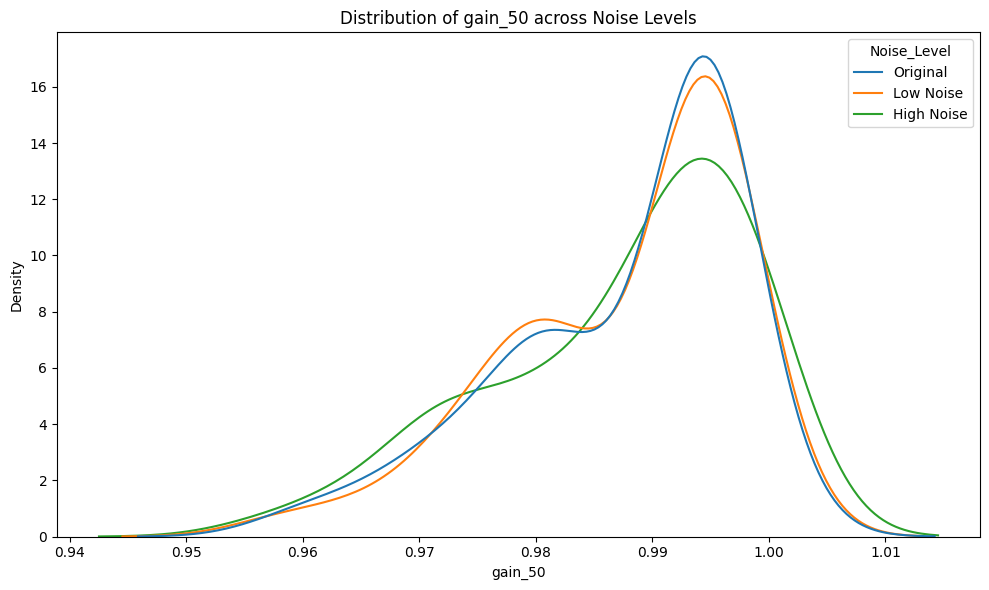


Analysis complete! Check the 'distribution_plots' directory for visualizations.


In [50]:
import os

def analyze_data_distribution(data_path):
    """
    Analyze and visualize the distribution of the augmented dataset
    """
    # Load the augmented data
    print("Loading augmented data...")
    df = pd.read_csv(data_path)
    
    # Create a directory for plots if it doesn't exist
    os.makedirs('distribution_plots', exist_ok=True)
    
    # 1. Distribution of samples across categories
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x='Product_Type', hue='Storage_Condition')
    plt.title('Distribution of Samples across Categories')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('distribution_plots/category_distribution.png')
    plt.close()
    
    # 2. Box plots for gain and phase features
    gain_cols = [col for col in df.columns if col.startswith('gain')]
    phase_cols = [col for col in df.columns if col.startswith('phase')]
    
    # Calculate statistics for gain features
    gain_stats = df[gain_cols].agg(['mean', 'std', 'min', 'max'])
    print("\nGain Features Statistics:")
    print(gain_stats.describe())
    
    # Box plot for gain values by product type
    
    plt.figure(figsize=(15, 5))
    # 2. Original Data Distribution
    # define gain_columns
    gain_columns = [col for col in df.columns if col.startswith('gain')]
    sns.histplot(data=original_data[gain_columns].values.ravel(), 
                color='blue', alpha=0.7)
    plt.title('Distribution of Original Data')
    plt.tight_layout()
    plt.savefig('distribution_plots/gain_distribution.png')
    plt.close()
    
    # 3. Check for outliers using IQR method
    def detect_outliers(data):
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
        return outliers
    
    print("\nNumber of outliers in gain features:")
    outliers_gain = {col: detect_outliers(df[col]) for col in gain_cols}
    print(pd.Series(outliers_gain).describe())
    
    # 4. Correlation heatmap (sample of features)
    plt.figure(figsize=(12, 8))
    # Select a subset of features to make the heatmap readable
    selected_features = gain_cols[:10] + phase_cols[:10]
    correlation_matrix = df[selected_features].corr()
    sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False)
    plt.title('Correlation Heatmap (First 10 Gain and Phase Features)')
    plt.tight_layout()
    plt.savefig('distribution_plots/correlation_heatmap.png')
    plt.close()
    
    # 5. Distribution of features by noise level
    def get_noise_level(filename):
        if 'high_noise' in filename:
            return 'High Noise'
        elif 'low_noise' in filename:
            return 'Low Noise'
        return 'Original'
    
    df['Noise_Level'] = df['Filename'].apply(get_noise_level)
    
    # Plot distribution of a sample gain feature across noise levels
    plt.figure(figsize=(10, 6))
    sample_gain = gain_cols[50]  # Middle frequency
    sns.kdeplot(data=df, x=sample_gain, hue='Noise_Level')
    plt.title(f'Distribution of {sample_gain} across Noise Levels')
    plt.tight_layout()
    plt.savefig('distribution_plots/noise_level_distribution.png')
    plt.show()
    
    return df

# Run the analysis
df = analyze_data_distribution('augmented_bakery_data.csv')

print("\nAnalysis complete! Check the 'distribution_plots' directory for visualizations.")